# Test of the package

This notebook tests the function developed in the package, to make sure they are working as expected.

Also, the plots in the reports come from the first section of this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt
import seaborn as sns
from numbers import Number

from src.function_helper import FunctionHelper, Quadratic, LogAffineFunction, LogBarrier
from src.custom_types import Line
from src.optimisation import UnconstrainedOptimizer

from src.function_helper import LinearFunction, LogAffineFunction

np.seterr(divide="ignore", invalid="ignore")

import matplotlib.colors as colors

from src.optimisation import QuadraticBarrierMethod, LASSOProblem
from src.data_generator import generate_data
from src.optimisation import LASSOProblem


## LASSO problem with multiple $\mu$.

In [3]:
N = 100
D = 50
M = 2*D
ld = 10
X, y, beta_star, Q, p, A, b = generate_data(
    N=N, D=D, ld=ld, sigma=1, density=0.2
)

In [4]:
x0 = np.zeros(N)
t0 = 1
mu = 20

In [5]:
lasso = LASSOProblem(X, y, ld=ld)

In [6]:
lasso.cvxpy_solution()

Solving with CVXPY...
Optimal value: -129.9451


In [7]:
mus = [2, 5, 10, 20, 35, 50, 75, 100, 125, 150, 175, 200]

In [8]:
results = lasso.try_mus(
    mus=mus,
    x0=x0,
    t0=t0,
    error=1e-6,
    centering_kwargs=dict(
        alpha=0.2,
        beta=0.5,
        max_iter=100,
        max_t_iter=100
    ),
    verbose=False
)

100%|██████████| 12/12 [00:35<00:00,  2.95s/it, mu=200]


### Exemple of centering plot

In [9]:
lasso.pbs[2].mu, lasso.pbs[2].ts[2]

(10, 100)

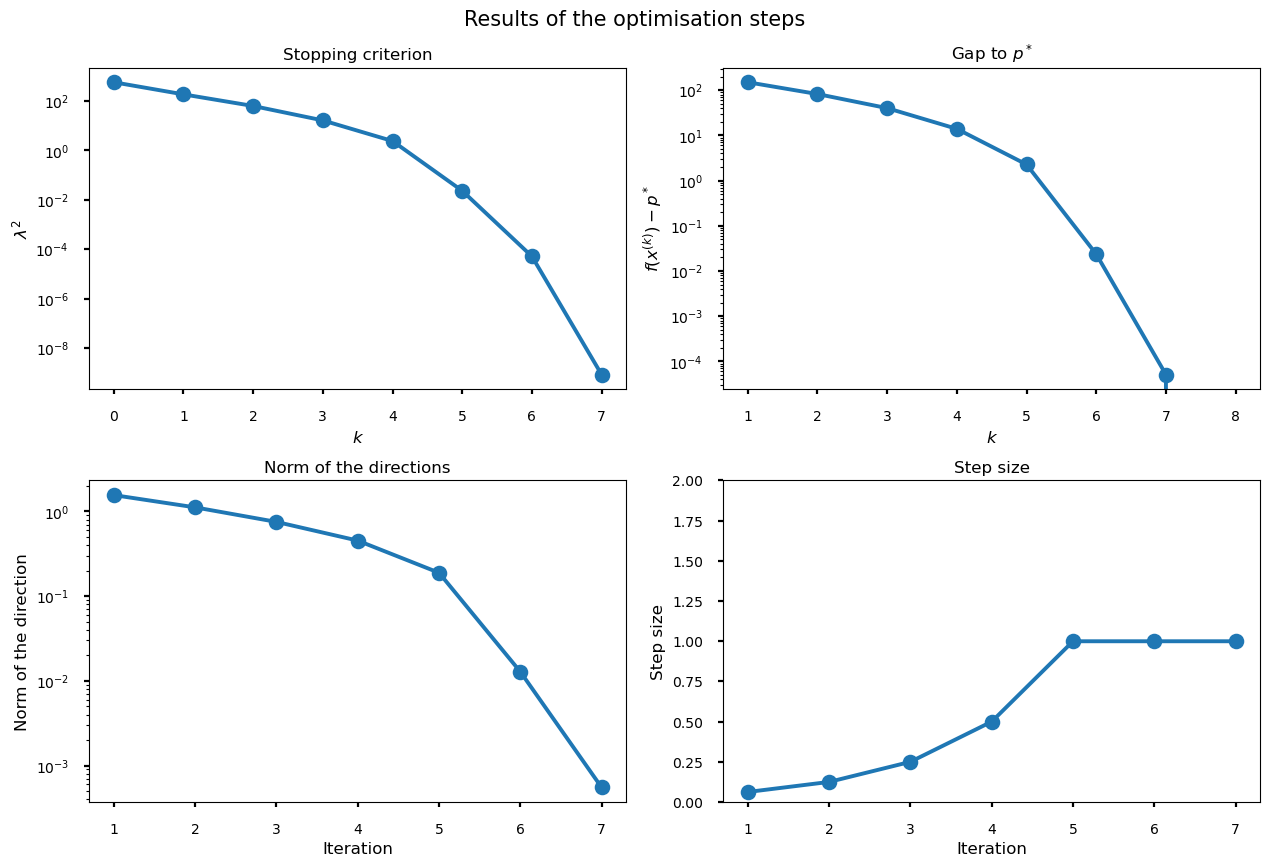

In [10]:
center_fig = lasso.pbs[2].center_pbs[2].plot_ouptuts()

### Exemple of lasso plot

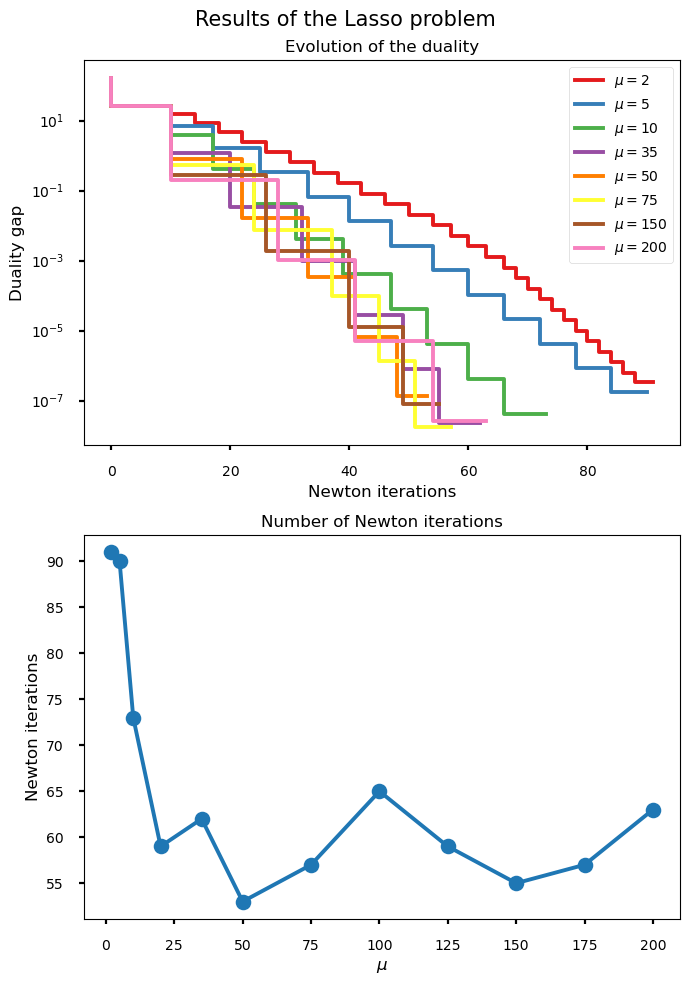

In [11]:
fig = lasso.plot_results(
    submus=[2, 5, 10,  35, 50, 75, 150, 200],
    figsize=(7, 10)
)

In [12]:
lasso.compare_with_cvxpy()

(4.63402728900268e-08, 1.374695557387895e-08)

In [13]:
w_star = lasso.get_w_star()

In [14]:
mu = lasso.mu
gap = lasso.calculate_dual_gap()[0][-1]
print(f"The final dual gap for the mu={mu} model: {gap: .6g}")

The final dual gap for the mu=200 model:  2.5949e-08


In [15]:
lasso.lasso_func(w_star)

129.9451147699327

In [16]:
np.where(w_star>=1e-5, w_star, 0)

array([0.        , 0.01118423, 0.06979384, 0.        , 0.        ,
       0.        , 0.13301761, 0.        , 0.20999201, 0.0149517 ,
       0.        , 0.        , 0.        , 0.        , 0.09410407,
       0.        , 0.        , 0.        , 0.        , 0.10858152,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05109365, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.45558223,
       0.        , 0.07117972, 0.        , 1.44966444, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

## CVXPY on dual problem

In [17]:
import cvxpy as cp

x = cp.Variable(N)
prob = cp.Problem(cp.Minimize(cp.quad_form(x, Q) + p.T @ x),
                 [A @ x <= b])
prob.solve()

prob.value, x.value

(-129.94511475773066,
 array([ 0.31552562, -0.11703727,  0.01728237, -0.61737851, -0.99928907,
         1.46258562, -0.42576194,  0.8568421 , -0.28038062, -0.56092876,
        -0.65274369,  0.29339506,  0.31064405, -0.89736969, -1.7106127 ,
        -1.21882627,  0.7451865 ,  1.78745409, -0.35292253, -1.38315793,
        -0.26489221,  0.00563829,  0.3942802 , -0.00680659, -0.92309693,
         0.06081644,  0.10674194,  1.11850177,  1.64766325,  0.70049316,
         0.98543705, -0.52862293, -0.26416066, -1.50249411,  1.8282942 ,
         0.3445711 ,  0.21621665, -1.34963551,  0.18589437,  1.17286416,
        -0.1218349 ,  1.1707134 ,  0.61834599, -0.16522791,  0.31948091,
         1.71364731,  0.81019719,  0.26572859,  0.38634092,  0.30676617,
         0.10183189, -0.35887503, -1.8900325 ,  0.95092626,  0.13033911,
        -2.07744882, -1.19539063, -2.35701503,  1.03831051, -0.12284202,
        -0.11956244,  0.87448636, -0.02591839, -1.93634463, -1.33856515,
        -1.25210765,  0.31492

We see that both solution are almost the same.

* The $\ell_2$-norm of the difference between the optimal points is less than $5 \times 10^{-14}$.
* The difference between the values of the function is less than $2 \times 10^{-17}$.

## CVXPY on LASSO problem

In [18]:
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

In [19]:
import cvxpy as cp

beta = cp.Variable(D)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X, y, beta, lambd)))

lambd_values = [ld]
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X, y, beta))
    beta_values.append(beta.value)

In [20]:
beta.value, problem.value

(array([-2.90270016e-09,  7.92692731e-02,  1.34435373e-01, -1.72464926e-02,
         2.72999932e-03,  5.61314165e-09,  1.61707656e-01, -8.57442237e-01,
         2.42599218e-01,  8.22894412e-02, -1.05049032e-01, -1.85735414e+00,
        -1.97530310e-01, -2.26990429e-01,  1.84052181e-01, -1.28541609e-08,
        -9.81794887e-02,  4.91859302e-09,  6.68202996e-09,  1.80605570e-01,
        -1.02559077e+00, -7.90144822e-02,  6.11321474e-02, -9.36582556e-02,
        -3.22492924e-02,  1.93421356e-02,  3.13858084e-02, -2.16119371e-02,
         9.52236784e-02,  1.02027203e-02, -7.01259311e-01, -3.11954241e-08,
        -6.82237946e-02,  1.02237050e-01,  3.39646544e-02, -4.35126008e-10,
        -1.08016295e+00, -2.49107690e-09, -9.02290388e-02,  5.31922055e-01,
         1.78976804e-02,  1.52451215e-01, -7.97568495e-09,  1.48752488e+00,
        -3.95189996e-02, -3.86015758e-02,  3.82741770e-03,  1.13658006e-01,
        -3.11355905e-09, -7.90449637e-09]),
 167.183396521373)

## Test of the Newton method

In [21]:
Q = np.array([[1, 2], [2, 4]])
p = np.array([1, -1])

test_func = Quadratic(Q=Q, p=p)

test_func_2 = test_func + 10
test_func_3 = test_func * 2

In [22]:
t_range = (-11, 10)
x0 = np.array([0, 0])
direction = np.array([1, 1])
n = 1000
offset = 1
order = 1

In [23]:
line = Line(
    x0=np.array([0, 0]),
    direction=np.array([1, 1])
)

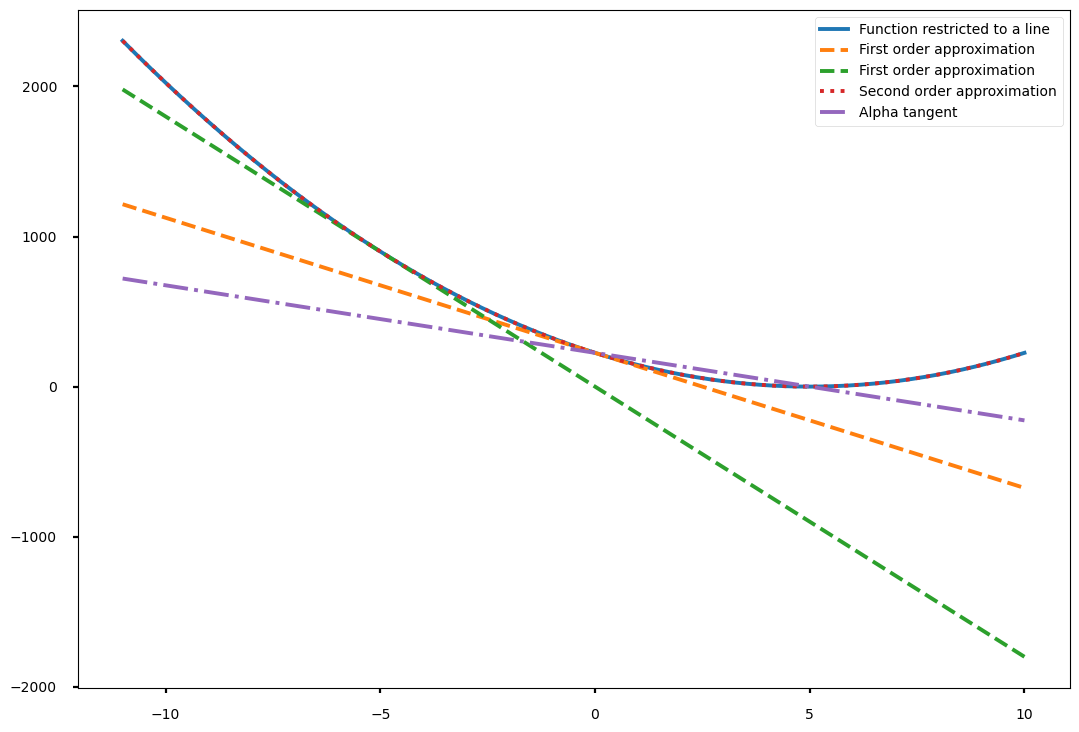

In [24]:
fig, ax = plt.subplots()

line = Line(
    x0=np.array([-5, -5]),
    direction=np.array([1, 1]),
    t_range=(-11, 10),
    n=1000
)

test_func.plot_line(line, ax=ax, label="Function restricted to a line")
test_func.plot_taylor_approximation(line, order=1, ax=ax, linestyle='--', label="First order approximation")
test_func.plot_taylor_approximation(line, order=1, offset=-5, ax=ax, linestyle='--', label="First order approximation")
test_func.plot_taylor_approximation(line, order=2, ax=ax, linestyle='dotted', label="Second order approximation")
test_func.plot_alpha_tangent(line, alpha=0.5, ax=ax, linestyle='-.', label="Alpha tangent")

In [25]:
N = 100
Q = nprd.uniform(-1, 1, size=(N, N))
p = nprd.uniform(-1, 1, size=(N))

In [26]:
ex_f = Quadratic(Q.T @ Q/10, p)
x0 = np.zeros(N)

In [27]:
pb = UnconstrainedOptimizer(ex_f, x0, method="gradient", epsilon=0)
pb.update_dir()

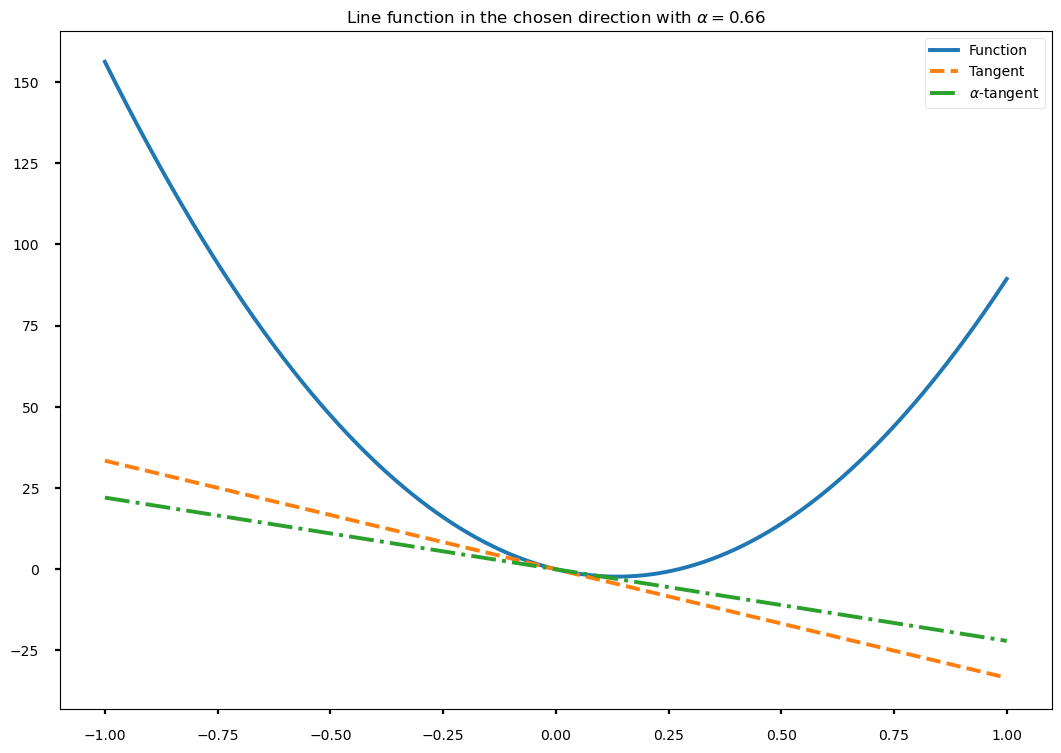

In [28]:
pb.plot_line(0.66, (-1, 1))

In [29]:
pb.optimise(1e-8, alpha=0.66, beta=0.66, verbose=False)

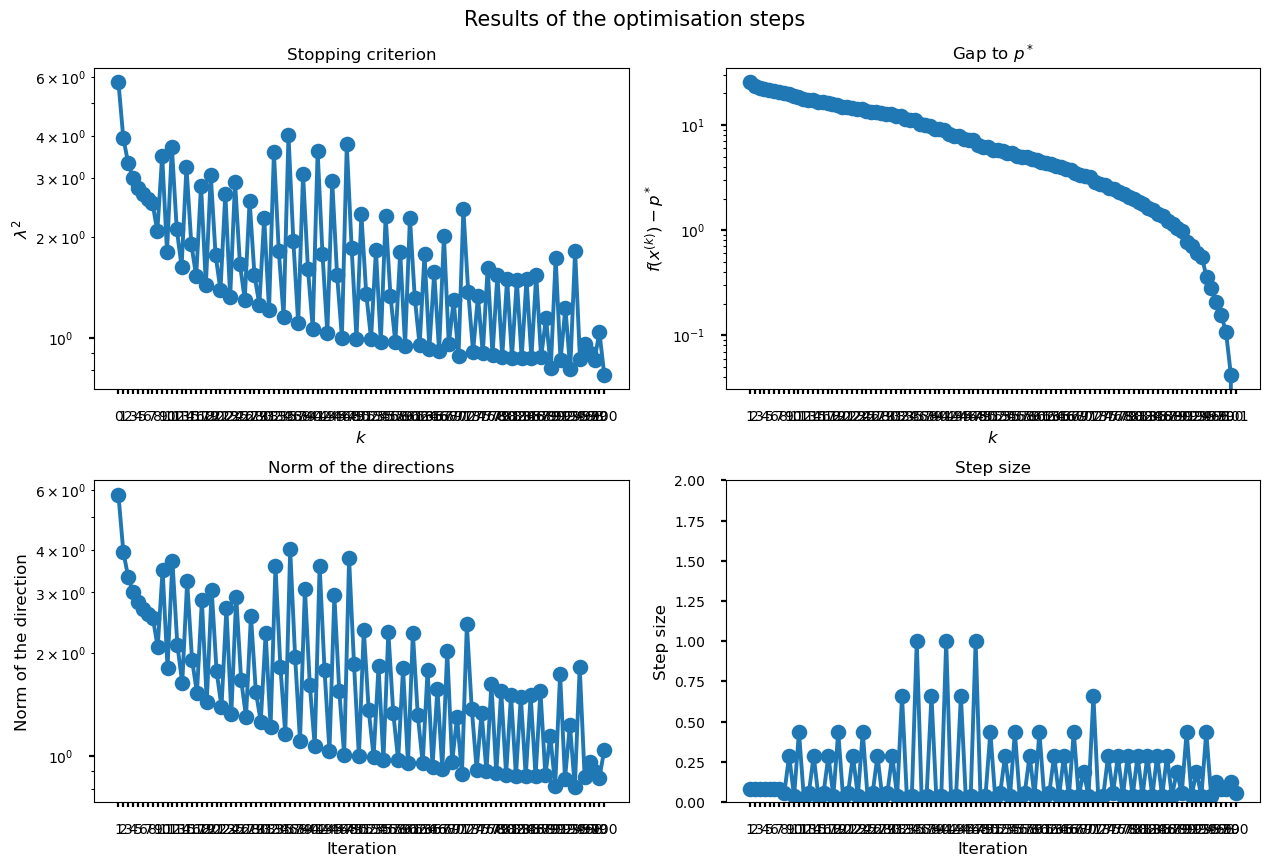

In [30]:
pbf = pb.plot_ouptuts()

## Example on a log barrier function

In [31]:
N = 5
I = 2

In [32]:
c = nprd.uniform(-1, 1, size=(N, N))
b = nprd.uniform(1, 5, size=(I,))
a = nprd.uniform(-1, 1, size=(I, N))
Q = nprd.uniform(-1, 1, size=(N, N))
p = nprd.uniform(-1, 1, size=(N))
x = np.zeros(N)

In [33]:
log_aff_0 = LogAffineFunction(a[0, :], b[0])
log_aff_1 = LogAffineFunction(a[1, :], b[1])
lin_f = LinearFunction(c)
quad_f = Quadratic(Q.T @ Q/100, p)
objective = quad_f + log_aff_0 + log_aff_1

In [34]:
objective(x)

-2.0966786934340624

In [35]:
pbl = UnconstrainedOptimizer(objective, x, method="newton", max_iter=100)

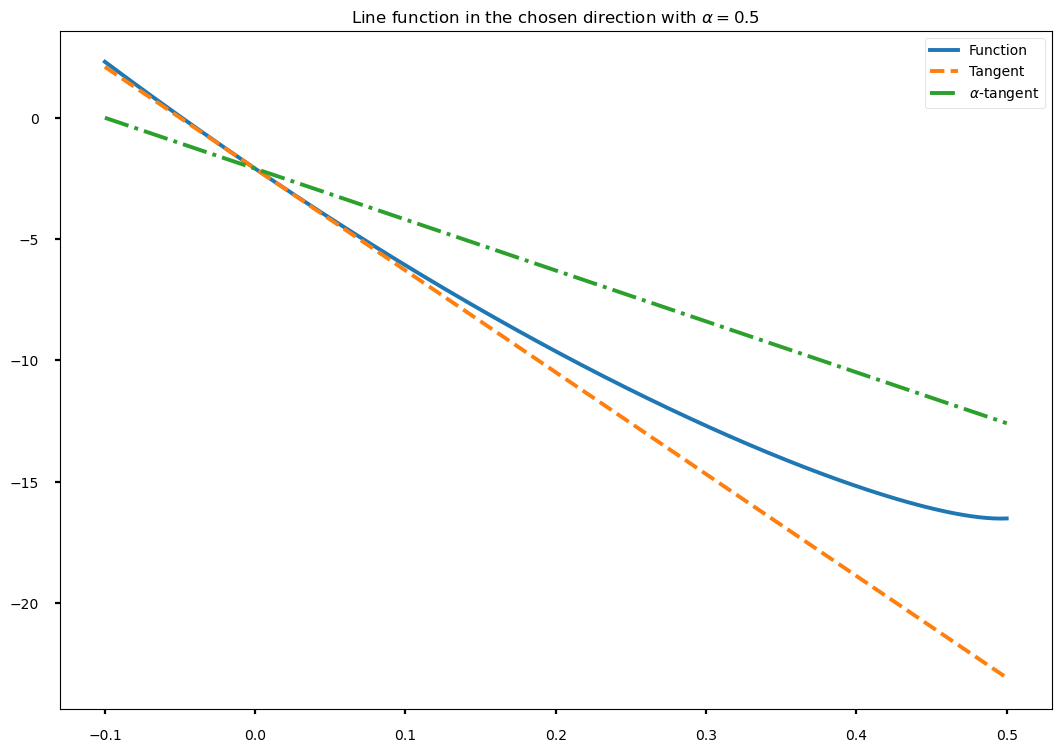

In [36]:
pbl.plot_line(0.5, t_range=(-0.1, 0.5))

In [37]:
error, alpha, beta = 1e-8, 0.4, 0.5
pbl.optimise(error, alpha, beta, verbose=True)

Step 1:
	 Criterion = 4.99e+00
	 y_1 = -17
	 y_0 - y_1 = 14
Step 2:
	 Criterion = 1.90e-01
	 y_2 = -22
	 y_1 - y_2 = 5.1
Step 3:
	 Criterion = 7.07e-02
	 y_3 = -22
	 y_2 - y_3 = 0.24
Step 4:
	 Criterion = 9.57e-03
	 y_4 = -22
	 y_3 - y_4 = 0.084
Step 5:
	 Criterion = 1.71e-04
	 y_5 = -22
	 y_4 - y_5 = 0.01
Step 6:
	 Criterion = 5.41e-08
	 y_6 = -22
	 y_5 - y_6 = 0.00017
Step 7:
	 Criterion = 5.39e-15
	 y_7 = -22
	 y_6 - y_7 = 5.4e-08
Last step 7:
	 Criterion = 5.39e-15
	 y_7 = -22


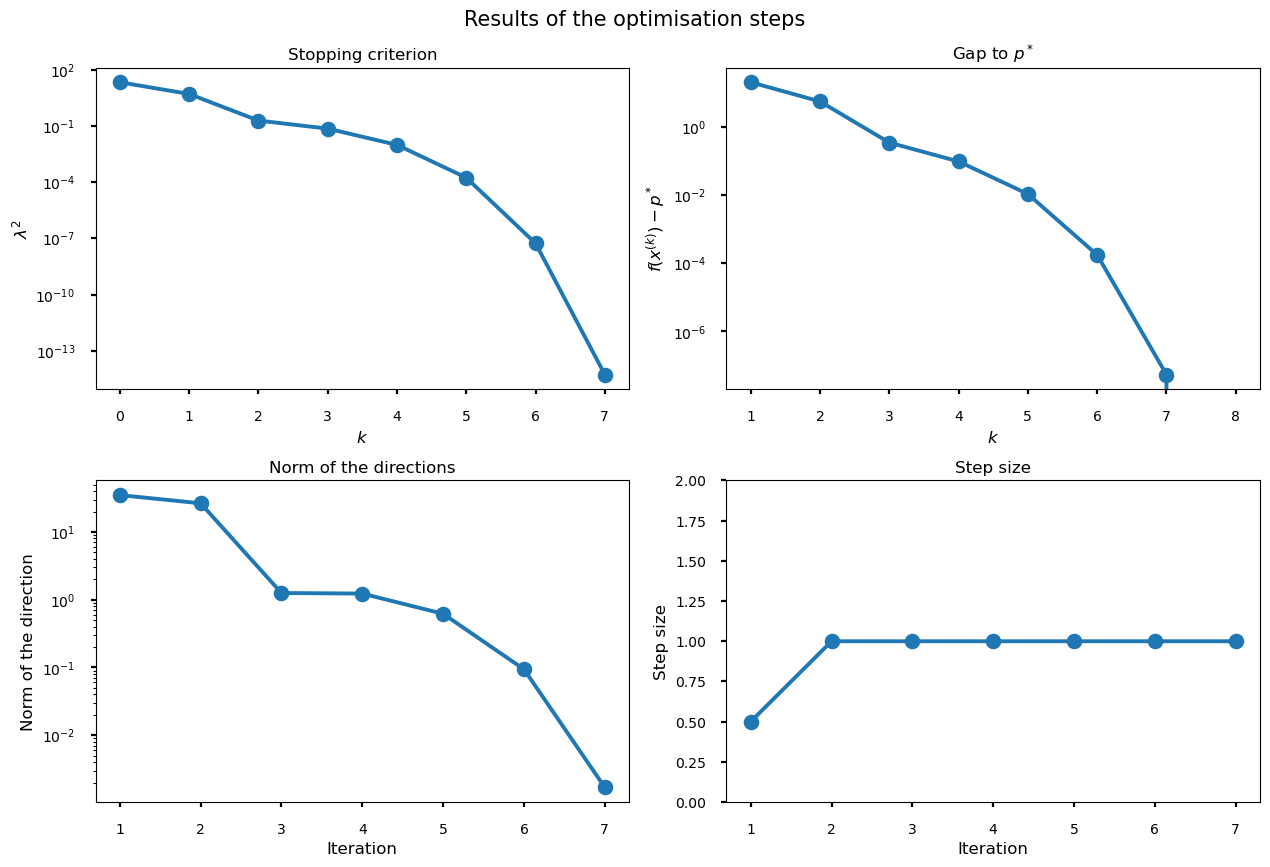

In [38]:
resfig = pbl.plot_ouptuts()

## 2D nonquadratic optimization example

\begin{equation}
f(x_1, x_2) = e^{x_1 + 3 x_2 - 0.1} + e^{x_1 - 3 x_2 - 0.1} + e^{-x_1 - 0.1}
\end{equation}

In [39]:
c1 = np.array([1, 3])
c2 = np.array([1, -3])
c3 = np.array([-1, 0])
f = lambda x: np.exp(c1 @ x - 0.1) + np.exp(c2 @ x - 0.1) + np.exp(c3 @ x - 0.1)
g = lambda x: np.array([
    np.exp(c1 @ x - 0.1) + np.exp(c2 @ x - 0.1) - np.exp(c3 @ x - 0.1),
    3*np.exp(c1 @ x - 0.1) - 3*np.exp(c2 @ x - 0.1)
])
h = lambda x: np.array([
    [
        np.exp(c1 @ x - 0.1) + np.exp(c2 @ x - 0.1) + np.exp(c3 @ x - 0.1),
        3*np.exp(c1 @ x - 0.1) - 3*np.exp(c2 @ x - 0.1),
    ],
    [
        3*np.exp(c1 @ x - 0.1) - 3*np.exp(c2 @ x - 0.1),
        9*np.exp(c1 @ x - 0.1) + 9*np.exp(c2 @ x - 0.1)
    ]
])

In [40]:
nqf = FunctionHelper(f, g, h)
x0 = np.array([-0.5, 0.5])
x1 = 0.9*np.array([1, 1])
pbnq = UnconstrainedOptimizer(func=nqf, x0=x0, method="newton")
pbnq2 = UnconstrainedOptimizer(func=nqf, x0=x0, method="gradient")
pbnq3 = UnconstrainedOptimizer(func=nqf, x0=x1, method="newton")
pbnq4 = UnconstrainedOptimizer(func=nqf, x0=x1, method="gradient")

In [41]:
pbnq.optimise(error=1e-12, alpha=0.1, beta=0.7, verbose=False)
pbnq2.optimise(error=1e-12, alpha=0.4, beta=0.7, verbose=False)
pbnq3.optimise(error=1e-12, alpha=0.1, beta=0.7, verbose=False)
pbnq4.optimise(error=1e-12, alpha=0.4, beta=0.2, verbose=False)

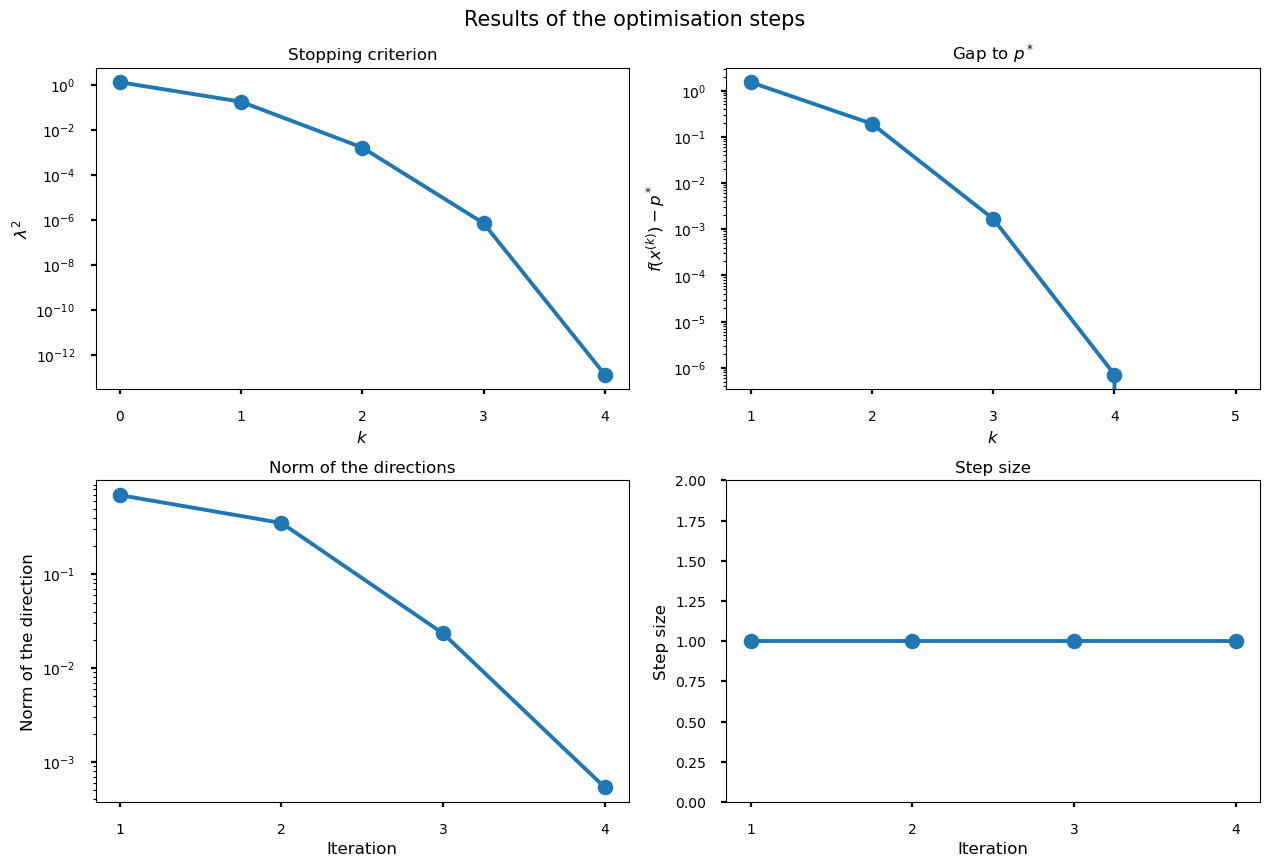

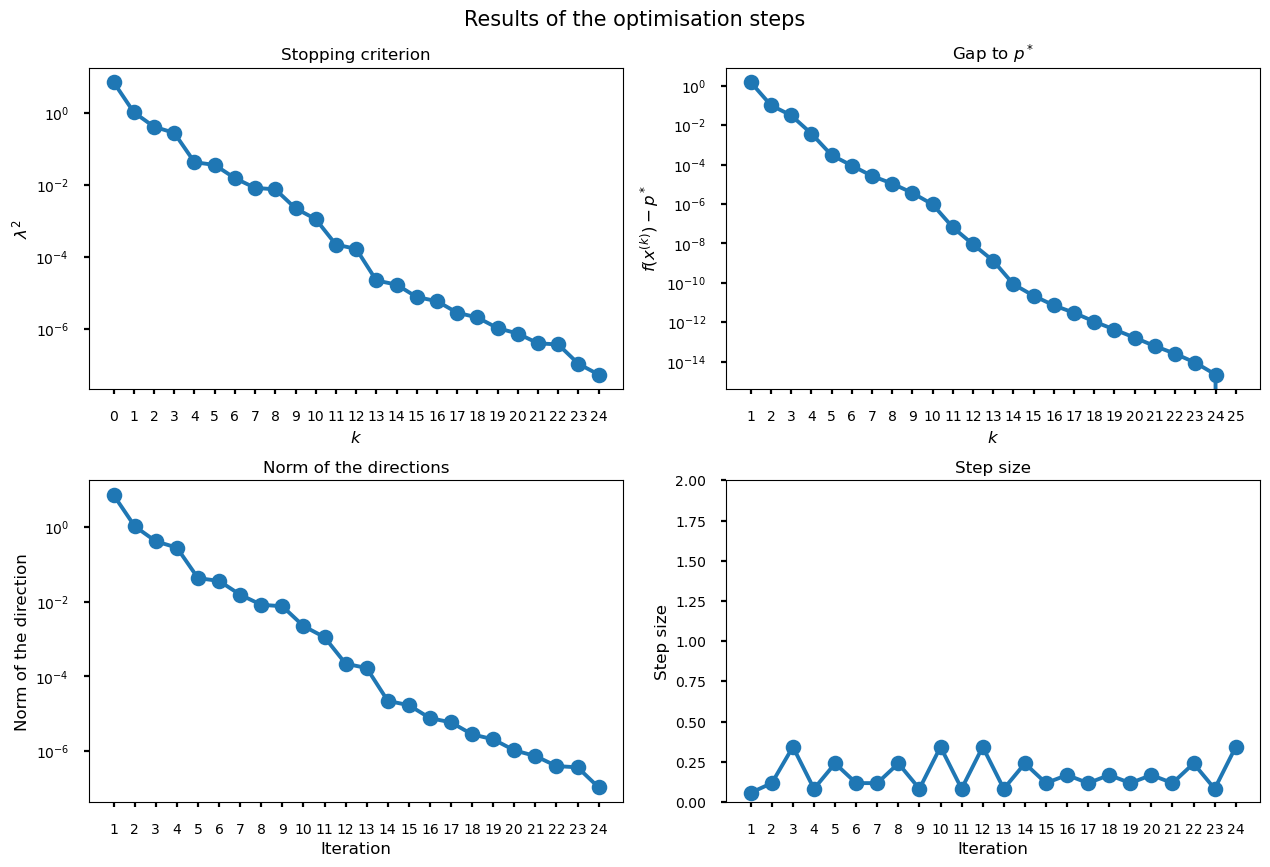

In [42]:
fignq = pbnq.plot_ouptuts()
fignq2 = pbnq2.plot_ouptuts()

In [43]:
min, max, step = -1, 1, 0.01
x, y = np.mgrid[min:max:step, min:max:step]
p = np.stack((x, y), axis=2)
z = np.array([[f(p[i, j]) for j in range(p.shape[1])] for i in range(p.shape[0])])

In [44]:
points = np.array(pbnq.xs)
points2 = np.array(pbnq2.xs)
points3 = np.array(pbnq3.xs)
points4 = np.array(pbnq4.xs)

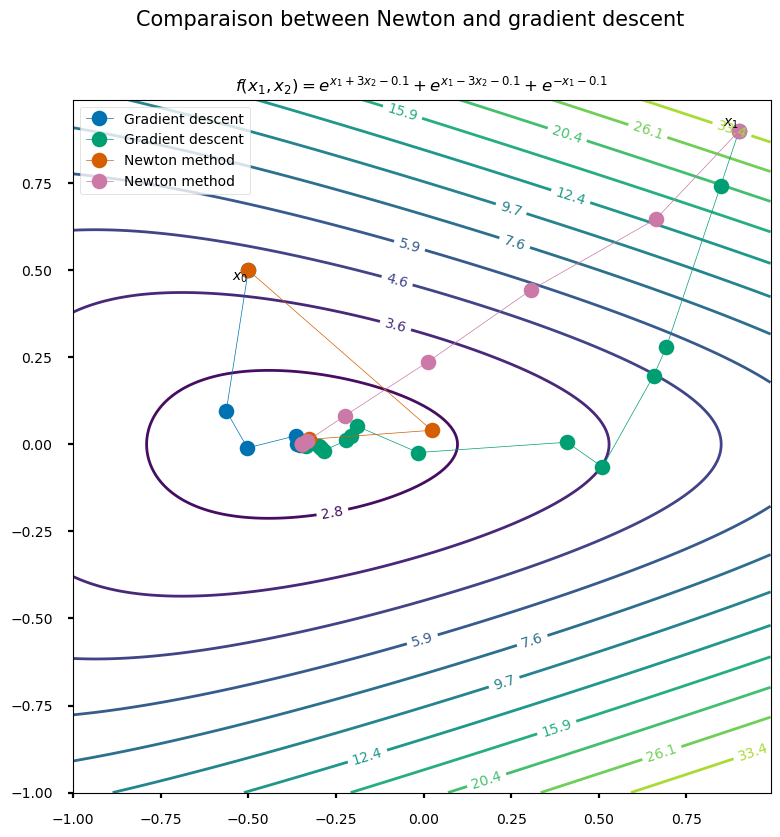

In [45]:
plt.style.use('seaborn-v0_8-colorblind')
fig, ax = plt.subplots(figsize=(9,9))
# im = ax.imshow(z,cmap=plt.cm.RdBu) # drawing the function
# adding the Contour lines with labels
min_z, max_z = np.log(1.1*np.min(z)), 0.9*np.log(np.max(z))
levels = np.exp(np.linspace(min_z, max_z, 11))
# cset = ax.contour(z, np.exp(np.linspace(min_z, max_z, 10)), linewidths=2, cmap=plt.cm.Set2)
cset = ax.contour(x, y, z, levels=levels, linewidths=2, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=z.min(), vmax=z.max()))
ax.clabel(cset, inline=True, fmt='%1.1f', fontsize=10)
# plt.colorbar(cset) # adding the colobar on the right
# latex fashion title
plt.title('$f(x_1, x_2) = e^{x_1 + 3 x_2 - 0.1} + e^{x_1 - 3 x_2 - 0.1} + e^{-x_1 - 0.1}$')
# ax.set(xticks=x[::10, 0], yticks=y[0, ::10])
plt.plot(points2[:, 0], points2[:, 1], marker='o', lw=0.5, label='Gradient descent')
plt.plot(points4[:, 0], points4[:, 1], marker='o', lw=0.5, label='Gradient descent')
plt.plot(points[:, 0], points[:, 1], marker='o', lw=0.5, label='Newton method')
plt.plot(points3[:, 0], points3[:, 1], marker='o', lw=0.5, label='Newton method')
plt.annotate('$x_0$', x0, horizontalalignment='right', verticalalignment='top')
plt.annotate('$x_1$', x1, horizontalalignment='right', verticalalignment='bottom')
fig.suptitle("Comparaison between Newton and gradient descent")
plt.legend(frameon=True)
plt.show()

## Test of the Barrier method on a quadratic function

In [46]:
def generate_data(N=20, D=50, ld=10, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(D)
    idxs = np.random.choice(range(D), int((1-density)*D), replace=False)
    for idx in idxs:
        beta_star[idx] = 0
    X = np.random.randn(N,D)
    y = X.dot(beta_star) + np.random.normal(0, sigma, size=N)
    Q = 0.5*np.identity(N)
    p = y
    A = np.vstack((X.T, -X.T))
    b = ld * np.ones(M)
    return X, y, beta_star, Q, p, A, b

In [47]:
N = 20
D = 50
M = 2*D
X, y, beta_star, Q, p, A, b = generate_data(N=N, D=D, ld=10, sigma=0.1, density=0.2)

In [48]:
x0 = np.zeros(N)
t0 = 1
mu = 20
qp = QuadraticBarrierMethod(
    Q=Q,
    p=p,
    A=A,
    b=b,
    x0=x0,
    t0=t0,
    mu=mu,
    tol=0,
    error=1e-8,
    centering_kwargs=dict(
        alpha=0.2,
        max_iter=200,
        max_t_iter=200
    )
)

In [49]:
qp.optimise(verbose=True)

Step 1:
	 Criterion = 1.00e+02
	 y_1 = -39.5136
	 Centering step final criterion = 4.15507e-09
	 Number of steps in centering = 4
Step 2:
	 Criterion = 5.00e+00
	 y_2 = -47.8579
	 Centering step final criterion = 9.94288e-17
	 Number of steps in centering = 9
Step 3:
	 Criterion = 2.50e-01
	 y_3 = -48.2656
	 Centering step final criterion = 1.23969e-10
	 Number of steps in centering = 10
Step 4:
	 Criterion = 1.25e-02
	 y_4 = -48.285
	 Centering step final criterion = 1.08785e-13
	 Number of steps in centering = 7
Step 5:
	 Criterion = 6.25e-04
	 y_5 = -48.286
	 Centering step final criterion = 1.97568e-13
	 Number of steps in centering = 10
Step 6:
	 Criterion = 3.13e-05
	 y_6 = -48.286
	 Centering step final criterion = 2.12045e-10
	 Number of steps in centering = 5
Step 7:
	 Criterion = 1.56e-06
	 y_7 = -48.286
	 Centering step final criterion = 2.22198e-10
	 Number of steps in centering = 6
Step 8:
	 Criterion = 7.81e-08
	 y_8 = -48.286
	 Centering step final criterion = 4.49572e-0

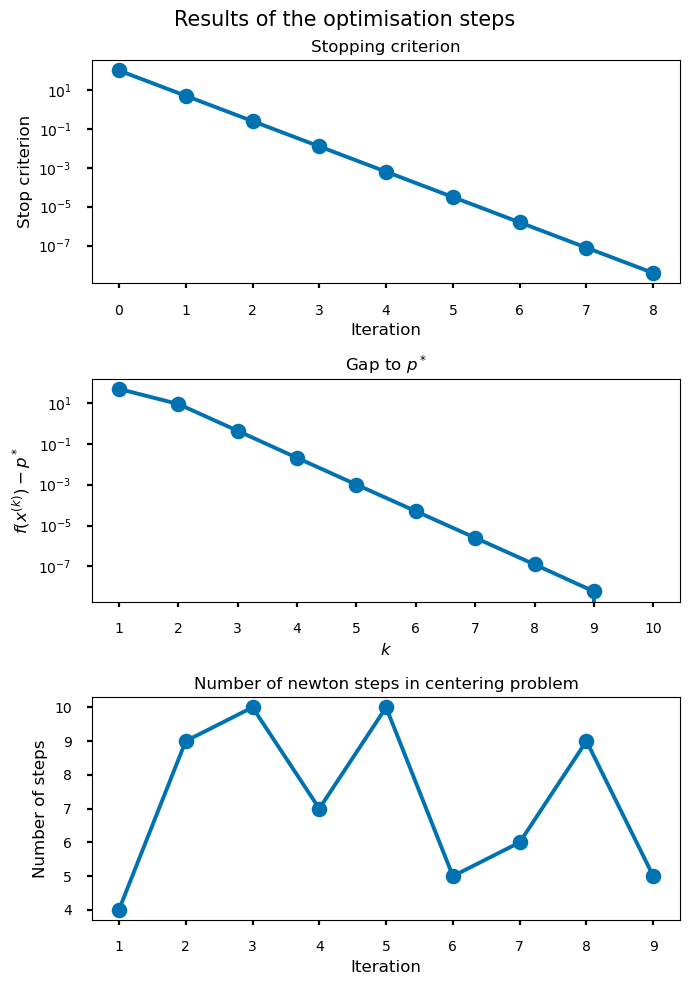

In [50]:
qpfig = qp.plot_ouptuts((7, 10))